Jednowymiarowy ruch pieszego opisany jest równaniem:
$$ m_i\frac{\operatorname{d}\!v_i}{\operatorname{d}\!t} = F_i $$
Gdzie 
$$ F_i = F_{i}^{drv} + F_{i}^{rep} $$
Pierwszy składnik związany jest z zamierzoną prędkością pieszego, do której dąży w swoim ruchu i wyraża się wzorem:
$$ F_{i}^{drv} = m_i \frac{v_i^0 - v_i}{\tau_i} $$
gdzie $\tau$ jest parametrem przyspieszenia. Wybieramy parametr ten stały dla wszystkich pieszych i równy $\tau = 0.61$ (zgodnie z [1] strona 4)

Drugi składnik $F_i^{rep}$ związany jest z kolei z odległością pomiędzy poszczególnymi pieszymi. W pierwszym przybliżeniu czynnik ten pomijamy.

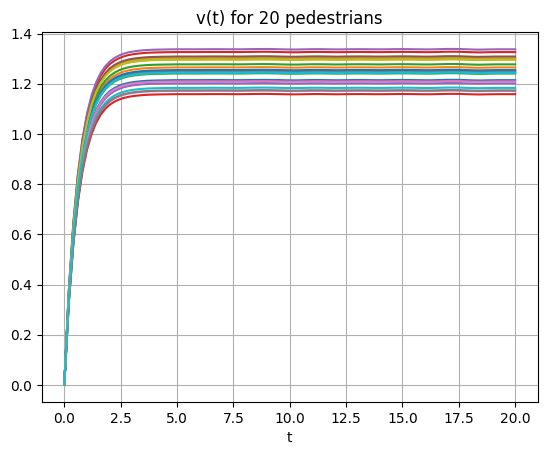

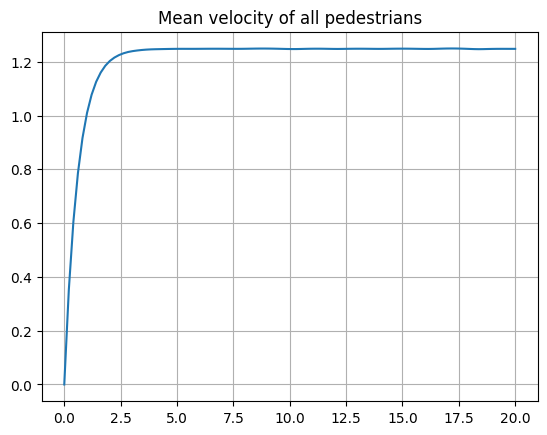

In [4]:
## rozwiązanie z użyciem wbudownych funkcji - prędkość
#bez uwzględniania interakcji między pieszymi
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

#simplified equation od pedestrian 
def pedestrian_vel(t,v, v0, tau):
    dvdt = (v0 - v)/tau
    return dvdt

v0s = np.random.normal(1.24, 0.05, 20) #zgodnie z [1] strona 4
tau = 0.61

#initial conditions
v_0 = 0  
t = np.linspace(0,20,100)
time_step = 20/100

#using explicit Runge-Kutta method of order 5(4)
sol = [ (solve_ivp(pedestrian_vel, (0.0,20.0),[0], method = 'RK45', args = (v0,tau), t_eval = t)).y[0] for v0 in v0s]
for i in range(20):
    plt.plot(t, sol[i])
plt.title("v(t) for 20 pedestrians")
plt.xlabel('t')
plt.grid()
plt.show()

mean_vel = np.mean(sol, axis =0)
plt.plot(t, mean_vel)
plt.title("Mean velocity of all pedestrians")
plt.grid()
plt.show()

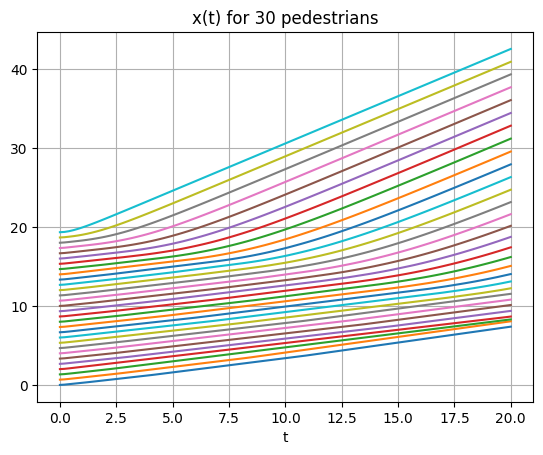

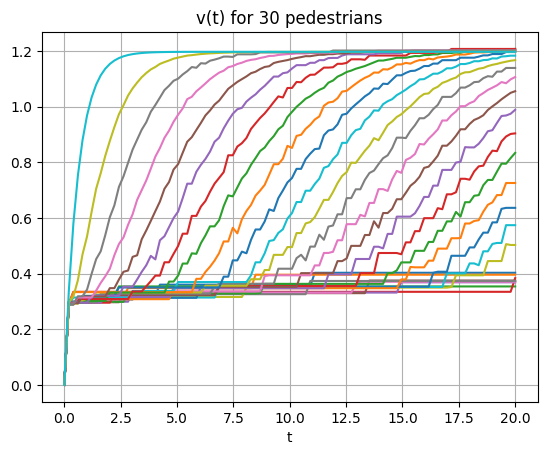

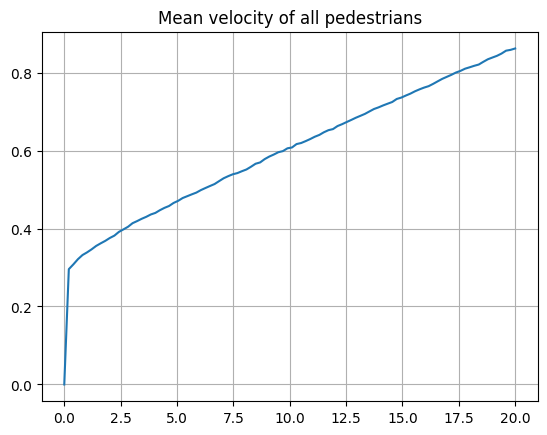

In [85]:
#układ równań - n pieszych
#uzwględnione interakcje - jeśli pieszy bezpośrednio przed jest bliżej niż 1m to przyspieszenie = 0, w przeciwnym razie dąży do zamierzonej prędkości 
#przyjmujemy przestrzeń o długości 20m

#simplified equation of pedestrian 
def pedestrian_vel(t,y, v0s, tau):
    #y - od 0 do n-1 - położenia od n do 2n-1 - prędkości
    n = len(v0s)
    dydt = np.zeros(2*n) #od 0 do n-1 - położenia od n do 2n-1 - prędkości
    for i in range(n):
        dydt[i] = y[-n+i]
    dydt[-1] = (v0s[-1] - y[-1])/tau #najdalszy pieszy 
    #pozostali - każdy zależnie od następnego
    for i in range(n,2*n-1):
        if y[i%n+1]-y[i%n]>=(0.36+1.06*y[i]):
            dydt[i] = (v0s[i%n] - y[i])/tau
        else:
            dydt[i] = 0 
    return dydt

#initial conditions
def initial(n):
    initial = np.zeros(2*n)
    for i in range(n):
        initial[i] = (20/n)*i
    return initial

t = np.linspace(0,20,100)

def simulate(n_pedestrians):
    v0s = np.random.normal(1.24, 0.05, n_pedestrians)#zgodnie z [1] strona 4
    tau = 0.61

    #using explicit Runge-Kutta method of order 5(4)
    solv_x = [ (solve_ivp(pedestrian_vel, (0.0,20.0),initial(n_pedestrians), method = 'RK45', args = (v0s,tau), t_eval = t)).y]

    for i in range(n_pedestrians):
        plt.plot(t, solv_x[0][i])
    plt.title(f"x(t) for {n_pedestrians} pedestrians")
    plt.xlabel('t')
    plt.grid()
    plt.show()

    for i in range(n_pedestrians,2*n_pedestrians):
        plt.plot(t, solv_x[0][i])
    plt.title(f"v(t) for {n_pedestrians} pedestrians")
    plt.xlabel('t')
    plt.grid()
    plt.show()


    mean_vel = np.mean(solv_x[0][n_pedestrians:], axis = 0)
    plt.plot(t, mean_vel)
    plt.title("Mean velocity of all pedestrians")
    plt.grid()
    plt.show()

simulate(30)

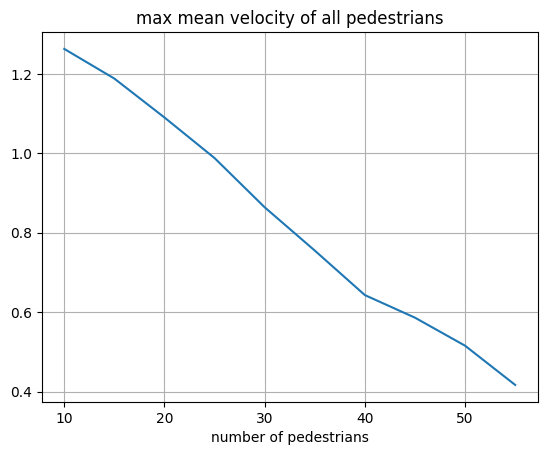

In [84]:
#porównanie liczby pieszych do średniej prędkości

def simulate_for_different_n(ns_pedestrians):
    max_mean_vels = []
    for n_pedestrians in ns_pedestrians:
        v0s = np.random.normal(1.24, 0.05, n_pedestrians)#zgodnie z [1] strona 4
        tau = 0.61

        #using explicit Runge-Kutta method of order 5(4)
        solv_x = [ (solve_ivp(pedestrian_vel, (0.0,20.0),initial(n_pedestrians), method = 'RK45', args = (v0s,tau), t_eval = t)).y]

        max_mean_vel = max(np.mean(solv_x[0][n_pedestrians:], axis = 0))
        max_mean_vels.append(max_mean_vel)

    plt.plot(ns_pedestrians, max_mean_vels)
    plt.title("max mean velocity of all pedestrians")
    plt.xlabel("number of pedestrians")
    plt.grid()
    plt.show()

simulate_for_different_n([10+5*n for n in range(10)])


IndexError: index 10 is out of bounds for axis 0 with size 2

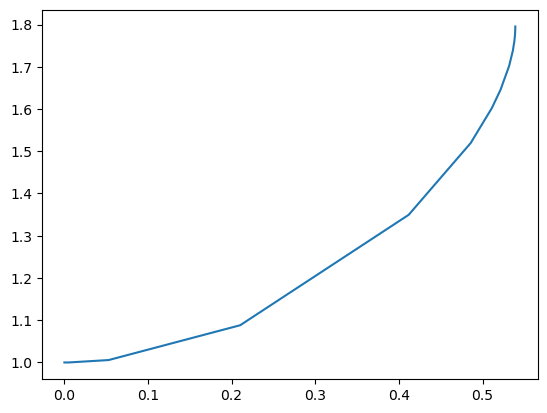

### N-wymiarowy ruch

C:\Users\user\AppData\Local\Temp\ipykernel_17596\682132855.py:66: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y[timestamp, 0, particle, 0], y[timestamp, 0, particle, 1], cmap=colors[particle])


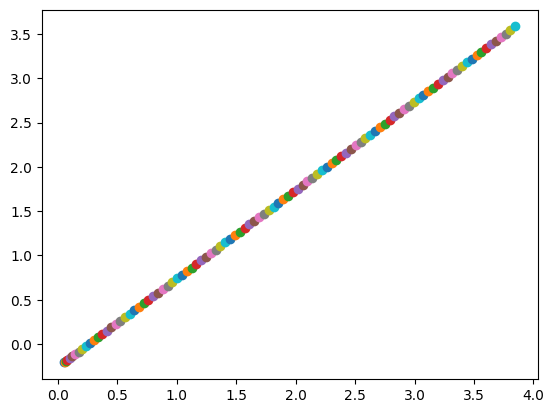

In [214]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def system(t, y, *params):
    
    n, dim, m, v_0, tau, a, b, d = params  
    
    y = y.reshape(2*n, dim)
    
    x = y[:n] # position
    v = y[n:] # velocity
    
    #driving forces dla systemu
    driving_forces = np.array([(v_0[i] - v[i])/tau[i] for i in range(n)])
    
    #repulsive forces dla wszystkich ludzi bez sumowania
    repulsive_forces = np.array([grad_rep_force(x[i], x[j], a[i], b[i], d[i])/m[i] for i in range(n) for j in range(n) if i != j])
    
    #sumowanie 
    repulsive_forces = np.sum(repulsive_forces.reshape((n, n-1, dim)), axis=1)
    
    total_forces = driving_forces + repulsive_forces
    
    return np.concatenate([v, total_forces]).flatten()
    

def grad_rep_force(x_i, x_j, A, B, d_i):
    
    norm = np.linalg.norm(x_i-x_j)
    vector_diff = x_i - x_j
    dist = max(norm - d_i, 0)
    if dist:
        return -B * (A / norm) * vector_diff * (dist) **(-B - 1)
    else: 
        return np.zeros_like(x_i)


#initial_conditions
dimention = 2
particles = 1
pos = np.random.rand(particles, dimention)-.5
vel = np.zeros((particles, dimention))
inital_conditions = np.concatenate([pos, vel]).flatten()


#params
m = np.random.rand(particles)
v_0 = np.random.rand(particles)
tau = np.random.rand(particles)
a = np.random.rand(particles)
b = np.random.rand(particles)
d = np.random.rand(particles)

params = (particles, dimention, m, v_0, tau, a, b, d)

t_span = (0, 10)

solution = solve_ivp(system, t_span, inital_conditions, args=params, t_eval=np.linspace(0, 10, 100))
y = np.transpose(solution.y).reshape(100, 2, particles, dimention)

colors = ['spring', 'summer', 'autumn', 'winter', 'cool']

for timestamp in range(100):
    for particle in range(particles):
        plt.scatter(y[timestamp, 0, particle, 0], y[timestamp, 0, particle, 1], cmap=colors[particle])

ruch dwuwymiarowy, zamierzony ruch w prawo lub lewo,
dwie poziome ściany, wartości parametrów głównie z głównego artykułu i ref 13

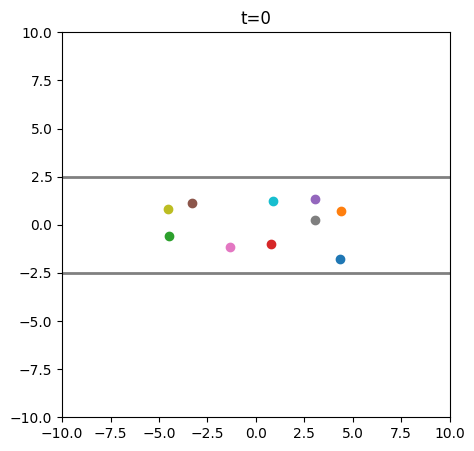

In [267]:
from IPython.display import HTML
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.animation as anim


def system(t, y, *params):
    
    n, m, v_0, tau, a, b, d, e, walls = params  
    
    y = y.reshape(2*n, 2)
    x = y[:n] # position
    v = y[n:] # velocity
    
    #driving forces dla systemu
    driving_forces = np.array([(v_0[i]*e[i] - v[i])/tau[i] for i in range(n)])
    
    #repulsive forces dla wszystkich ludzi bez sumowania
    repulsive_forces = np.array([grad_rep_force_others(x[i], x[j], a[i], b[i], d[i])/m[i] for i in range(n) for j in range(n) if i != j])
    #sumowanie 
    repulsive_forces = np.sum(repulsive_forces.reshape((n, n-1, 2)), axis=1)

    repulsive_forces_walls = np.array([grad_rep_force_walls(x[i], walls, a[i], b[i], d[i])/m[i] for i in range(n)])
    
    total_forces = driving_forces + repulsive_forces +repulsive_forces_walls
    
    return np.concatenate([v, total_forces]).flatten()
    
def grad_rep_force_others(x_i, x_j, A, B, d_i):
    norm = np.linalg.norm(x_i-x_j)
    vector_diff = x_i - x_j
    dist = max(norm - d_i, 0)
    if dist:
        return B * (A/(norm)) * vector_diff * (dist) **(-B - 1)
    else: 
        return np.zeros_like(x_i)
    
def grad_rep_force_walls(x_i, walls, A, B, d_i):
    if abs(x_i[1]-walls[0])<=abs(x_i[1]-walls[1]):
        vector_diff = x_i - [x_i[0],walls[0]]
        norm = np.linalg.norm(vector_diff)
    else:
        vector_diff = x_i - [x_i[0],walls[1]]
        norm = np.linalg.norm(vector_diff)
    dist = max(norm - d_i/2,0)
    if dist:
        return B * (A/norm) * vector_diff * (dist) **(-B - 1)
    else: 
        return np.zeros_like(x_i)


#initial_conditions
def generate_positions(num_vectors, min_x, max_x, min_y, max_y, min_distance):
    pos = []
    
    while len(pos) < num_vectors:
        vector = np.random.uniform([min_x, min_y], [max_x, max_y])
        if all(np.linalg.norm(np.array(vector) - np.array(existing_vector)) >= min_distance for existing_vector in pos):
            pos.append(vector)
    
    return np.array(pos)

particles = 10
pos = generate_positions(particles, -5,5,-2,2, 1)
vel = np.zeros((particles, 2))
inital_conditions = np.concatenate([pos, vel]).flatten()


#params
m = np.random.rand(particles)
v_0 = np.absolute(np.random.normal(1.24, 0.05, particles)) #zgodnie z artykułem
tau = np.full(particles, 0.5) #też zgodnie z artykułem - dla wszystkich równe
a = np.full(particles,0.2)
b = np.full(particles, 2)
d = np.full(particles,1)
e = [np.array([1,0])]*int(particles/2)
e.extend([np.array([-1,0])]*(particles-int(particles/2)))
walls = [-2.5,2.5] #zakładając poziome ściany i ruch prawo-lewo
params = (particles, m, v_0, tau, a, b, d, e, walls)

t_span = (0, 10)

solution = solve_ivp(system, t_span, inital_conditions, args=params, t_eval=np.linspace(0, 10, 50))

y = np.transpose(solution.y).reshape(50, 2, particles, 2)

#poglądowo
fig, ax = plt.subplots(figsize=(5,5))

def update(i):
    ax.clear()
    for particle in range(particles):
        ax.scatter(y[i, 0, particle, 0], y[i, 0, particle, 1])
    ax.plot(np.linspace(-12, 12, 100), np.full(100,2.5), color = "gray", linewidth = 2)
    ax.plot(np.linspace(-12, 12, 100), np.full(100,-2.5), color = "grey", linewidth = 2)

    ax.set_xlim(-10, 10) 
    ax.set_ylim(-10, 10)

    ax.set_title(f't={i}')

ani = anim.FuncAnimation(fig, update,frames=50,interval=200)
ani.save('animation.html', writer='html')
HTML(ani.to_jshtml())


### Bibliografia:

[1] Basics of modelling the pedestrian flow - Armin Seyfried, Bernhard Steffen, Thomas Lippert